In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


# **Data Loading and Cleaning**

In [4]:

df = pd.read_csv('shopping_trends.csv')
df.head()


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


In [5]:
df.isnull().sum()

Customer ID                 0
Age                         0
Gender                      0
Item Purchased              0
Category                    0
Purchase Amount (USD)       0
Location                    0
Size                        0
Color                       0
Season                      0
Review Rating               0
Subscription Status         0
Payment Method              0
Shipping Type               0
Discount Applied            0
Promo Code Used             0
Previous Purchases          0
Preferred Payment Method    0
Frequency of Purchases      0
dtype: int64

# **Feature Engineering**

In [6]:
# 1 handling categorical variables using encoding

# Create a copy of the dataframe
df_processed = df.copy()

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical columns
le = LabelEncoder()
for column in categorical_columns:
    df_processed[f'{column}_encoded'] = le.fit_transform(df_processed[column])



In [7]:
# 2 creating age-based features:

# Age groups
df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                 bins=[0, 18, 25, 35, 50, 65, 100],
                                 labels=['Under 18', '19-25', '26-35', '36-50', '51-65', '65+'])

# Convert Age_Group to numeric
df_processed['Age_Group_encoded'] = le.fit_transform(df_processed['Age_Group'])



In [8]:
# 3 creating purchase-based features:

# Average purchase amount per customer
avg_purchase = df_processed.groupby('Customer ID')['Purchase Amount (USD)'].transform('mean')
df_processed['Avg_Purchase_Amount'] = avg_purchase

# Purchase frequency score
df_processed['Purchase_Frequency_Score'] = df_processed['Previous Purchases'] / df_processed['Age']

# High value customer flag
df_processed['Is_High_Value'] = (df_processed['Purchase Amount (USD)'] > 
                                df_processed['Purchase Amount (USD)'].mean()).astype(int)




In [9]:
# 4 creating interaction features

# Interaction between Review Rating and Purchase Amount
df_processed['Rating_Purchase_Interaction'] = df_processed['Review Rating'] * df_processed['Purchase Amount (USD)']

# Interaction between Previous Purchases and Purchase Amount
df_processed['Previous_Current_Purchase_Interaction'] = df_processed['Previous Purchases'] * df_processed['Purchase Amount (USD)']





In [10]:
# 5 creating seasonal features

# Create season-based binary columns
seasons = pd.get_dummies(df_processed['Season'], prefix='Season')
df_processed = pd.concat([df_processed, seasons], axis=1)



In [11]:
# 6 creating discount-related features

# Convert Discount Applied to binary
df_processed['Has_Discount'] = (df_processed['Discount Applied'] == 'Yes').astype(int)

# Combine discount and promo code information
df_processed['Total_Promotions'] = ((df_processed['Discount Applied'] == 'Yes').astype(int) + 
                                  (df_processed['Promo Code Used'] == 'Yes').astype(int))


In [12]:
# 7 creating loyalty-related features

# Loyalty score based on multiple factors
df_processed['Loyalty_Score'] = (df_processed['Previous Purchases'] * 0.3 + 
                               (df_processed['Subscription Status_encoded'] * 0.3) +
                               (df_processed['Frequency of Purchases_encoded'] * 0.4))

# Normalize Loyalty Score
df_processed['Loyalty_Score'] = (df_processed['Loyalty_Score'] - df_processed['Loyalty_Score'].min()) / \
                               (df_processed['Loyalty_Score'].max() - df_processed['Loyalty_Score'].min())




In [13]:
# 8 Final cleanup

# Remove any duplicate columns or unnecessary features
columns_to_drop = ['Age_Group', 'Season']  # Add more columns if needed
df_processed = df_processed.drop(columns=columns_to_drop)

# Handle any missing values that might have been created
df_processed = df_processed.fillna(0)



In [14]:
df_processed.select_dtypes(exclude='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer ID                            3900 non-null   int64  
 1   Age                                    3900 non-null   int64  
 2   Purchase Amount (USD)                  3900 non-null   int64  
 3   Review Rating                          3900 non-null   float64
 4   Previous Purchases                     3900 non-null   int64  
 5   Gender_encoded                         3900 non-null   int32  
 6   Item Purchased_encoded                 3900 non-null   int32  
 7   Category_encoded                       3900 non-null   int32  
 8   Location_encoded                       3900 non-null   int32  
 9   Size_encoded                           3900 non-null   int32  
 10  Color_encoded                          3900 non-null   int32  
 11  Seas

# **Model Building**

In [15]:
X = df_processed.select_dtypes(exclude='object').drop('Purchase Amount (USD)', axis=1)
y = df_processed.select_dtypes(exclude='object')['Purchase Amount (USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [22]:
# Define a list of models
model = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]
model_names = [type(fmodel).__name__ for fmodel in model]
mse_values = []

# Train and evaluate each model
for fmodel in model:
    fmodel.fit(X_train, y_train)
    y_pred = fmodel.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    mse_values.append(mse)
    print('-'*100)
    print(f'{type(fmodel).__name__} with  mse: {mse}')

----------------------------------------------------------------------------------------------------
LinearRegression with  mse: 2.2507839220285894e-25
----------------------------------------------------------------------------------------------------
Ridge with  mse: 7.017546410666276e-09
----------------------------------------------------------------------------------------------------
Lasso with  mse: 0.005290335307576646
----------------------------------------------------------------------------------------------------
DecisionTreeRegressor with  mse: 0.0
----------------------------------------------------------------------------------------------------
RandomForestRegressor with  mse: 0.0
----------------------------------------------------------------------------------------------------
GradientBoostingRegressor with  mse: 0.0001236720344651391
----------------------------------------------------------------------------------------------------
XGBRegressor with  mse: 2.075611

In [23]:
best_model = pd.DataFrame({
    'model': model_names,
    'mse': mse_values
})
best_model = best_model.sort_values(by = 'mse' , ascending=True).head(2)
best_model

,model,mse
3,DecisionTreeRegressor,0.0
4,RandomForestRegressor,0.0


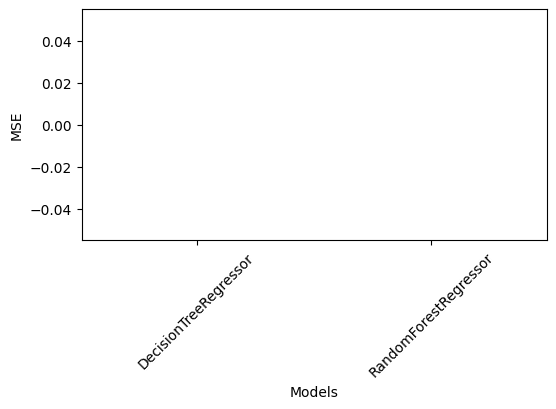

In [25]:
# Plot the RMSE values for each model
plt.figure(figsize=(6,3))
plt.bar(best_model['model'], best_model['mse'])
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.ylim()
plt.show()

# **Hyperparameter Tuning in DecisionTreeRegressor** 

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import pandas as pd
from joblib import parallel_backend
import multiprocessing
import time

def train_decision_tree_parallel(X_train, X_test, y_train, y_test, n_jobs=-1, n_iter=5):

    # Print number of CPU cores being used
    n_cores = multiprocessing.cpu_count()
    print(f"Number of CPU cores available: {n_cores}")
    
    # Start timing
    start_time = time.time()
    
    # Initialize the model
    dt_model = DecisionTreeRegressor(random_state=42)
    
    # Define the parameter distribution
    param_dist = {
        'max_depth': randint(1, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20)
    }
    
    # Use parallel backend for computation
    with parallel_backend('threading', n_jobs=n_jobs):
        # Initialize and fit RandomizedSearchCV
        random_search_dt = RandomizedSearchCV(
            estimator=dt_model,
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=5,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=n_jobs  # Use all cores
        )
        
        # Fit the model
        random_search_dt.fit(X_train, y_train)
    
    # Get best parameters and model
    best_params = random_search_dt.best_params_
    best_model = random_search_dt.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Create predictions DataFrame
    predictions_df = pd.DataFrame(y_pred[:5], columns=["Prediction"])
    
    # Print results
    print(f'\nTraining completed in {execution_time:.2f} seconds')
    print(f'Best parameters: {best_params}')
    print(f'Mean Squared Error: {mse}\n')
    print(f'First 5 Predictions:\n{predictions_df}')
    
    # Return results
    results = {
        'best_model': best_model,
        'predictions': y_pred,
        'mse': mse,
        'best_params': best_params,
        'execution_time': execution_time,
        'predictions_df': predictions_df,
        'cv_results': random_search_dt.cv_results_
    }
    
    return results




# **Model Evaluation**

In [29]:
results = train_decision_tree_parallel(X_train, X_test, y_train, y_test,n_iter=10)


Number of CPU cores available: 8

Training completed in 0.58 seconds
Best parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 12}
Mean Squared Error: 0.0

First 5 Predictions:
   Prediction
0        31.0
1        50.0
2        36.0
3        72.0
4        38.0


In [39]:
difference = pd.DataFrame({
    'Predicted':results['predictions'],
    'Actual': y_test
}).reset_index().drop('index', axis=1)
difference.head()


,Predicted,Actual
0,31.0,31
1,50.0,50
2,36.0,36
3,72.0,72
4,38.0,38


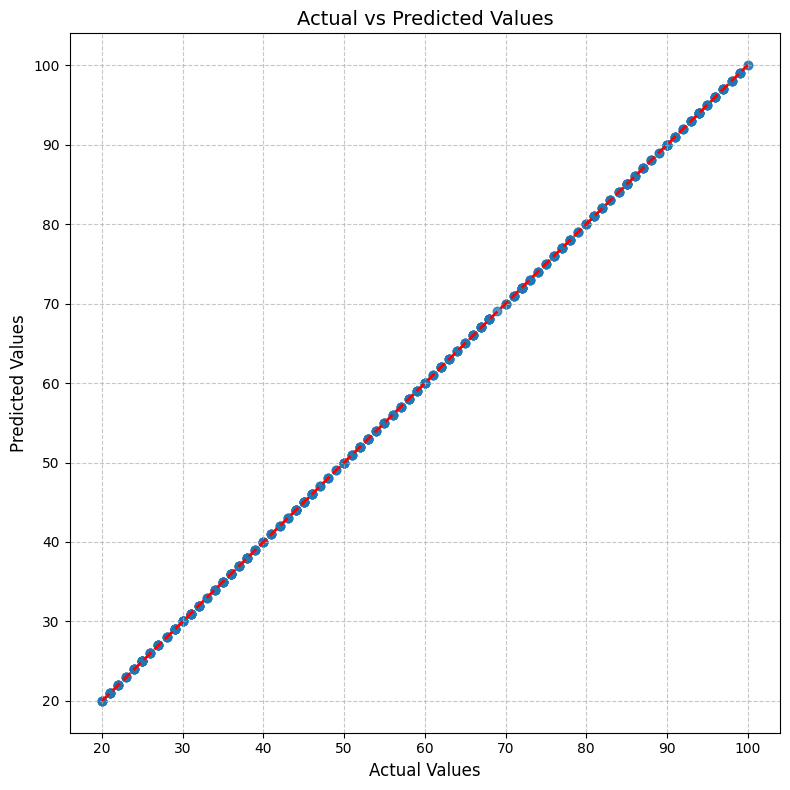

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(difference['Actual'], difference['Predicted'], alpha=0.5)
plt.plot([difference['Actual'].min(), difference['Actual'].max()], 
         [difference['Actual'].min(), difference['Actual'].max()], 
         'r--', lw=2)

plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
# In above chart:
# Points representing each prediction
# Red dashed line representing perfect predictions
# Points above the line indicate over-prediction
# Points below the line indicate under-prediction

<Axes: >

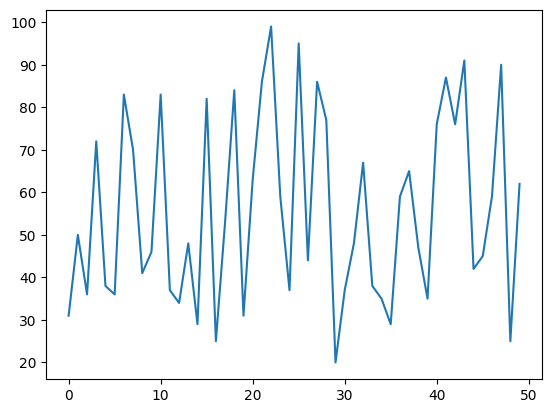

In [55]:
difference['Actual'].head(50).plot()

<Axes: >

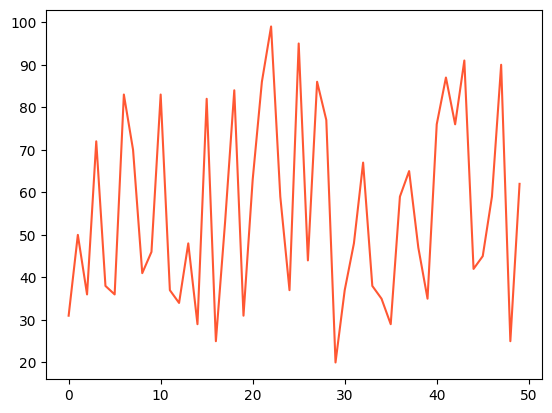

In [58]:
difference['Predicted'].head(50).plot(color='#FF5733')
